In [1]:
import os
from glob import glob
from pprint import pprint # pretty printing

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets

# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## 1. *Geddat that data*
we reduced our spiketime data into 'long' format data - where every row is an observation (in this case spikes) and every column a variable.

We also combined all cells into a single file with clean_out_dir.m. Let's load it

In [30]:
# start with tuning curves
tc_dir = os.path.join(os.getcwd(),'data','tones')
# make a string with a wildcard to search for the file
tc_search = tc_dir + os.sep + "*combined*.csv"
tc_fns = glob(tc_search)

#what did we get?
print("""\nDirectory: {}
          \nSearch string: {}
          \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))



Directory: /Users/jonny/GitHub/bootcamp_2018/data/tones
          
Search string: /Users/jonny/GitHub/bootcamp_2018/data/tones/*combined*.csv
          
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/tones/out_combined_tones.csv']


Load it!

In [31]:
if len(tc_fns) == 1:
    # make a pandas dataframe out of our .csv file
    df = pd.read_csv(tc_fns[0])
    
# print the first n rows (default 5, try giving another number as an argument)
df.head()

,amps,cell,dur,expt,freqs,rep,spikes
0,40,1,25,tuning_curve,4000.00,1,1.566667
1,40,1,25,tuning_curve,5656.85,1,21.633333
2,40,1,25,tuning_curve,11313.70,1,26.866667
3,40,1,25,tuning_curve,11313.70,1,36.366667
4,40,1,25,tuning_curve,22627.40,1,16.666667


How many cells do we have?

In [18]:
print("There are {} unique cells: {}".format(
        len(df['cell'].unique()), 
        df['cell'].unique()
    ))

There are 2 unique cells: [1 7]


The data is structured such that each row is a spike, and each column describes the spike.

Look at the rest of the column names - we have 

* **expt**: what type of experiment this data is from
* **freqs**: the frequency of the pure tone
* **amps**: the amplitude of the tone
* **rep**: the repetition of each amplitude/frequency combination
* **spikes**: the time of the spike (in ms from stimulus onset)

Lets check what `unique` frequencies and amplitudes we have

In [23]:
uq_freqs = df['freqs'].unique()
uq_amps  = df['amps'].unique()

print('Frequencies:\n')
pprint(uq_freqs)
print('\n\nAmplitudes:\n')
pprint(uq_amps)

Frequencies:

array([ 4.00000e+03,  5.65685e+03,  1.13137e+04,  2.26274e+04,
        1.00000e+03,  1.41421e+03, -1.00000e+00,  2.82843e+03,
        1.60000e+04,  6.40000e+04,  2.00000e+03,  8.00000e+03,
        3.20000e+04,  4.52548e+04])


Amplitudes:

array([40, 55, 70])


We presented probably like 9 stimuli:

## 2. Spike Raster

We make a classic raster first.

In [68]:

def spike_raster(cell, data):
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
    
    duration = data.loc[0].dur
    
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # black
        color=alt.condition(
            (alt.datum.spikes >= 0) & (alt.datum.spikes<=duration),
            alt.value('red'), # and opaque
            alt.value('black')
        )
        
    ).properties(
        width = 200,
        height = 30,
    ).facet(
        row='freqs', # split the plot into rows by ici
        column='amps'
    )
    
    
    return chart



In [69]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDcpLCB2YWx1ZT0xKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2XigKY=


## 3. Tuning Curves

What if we want to summarize? The receptive fields of auditory neurons are parameterized by the frequencies and amplitudes that drive spiking activity. We can map that by aggregating the spike trains across repetitions of the same sound.


In [71]:
# choose just one cell
#tc_cell = df['cell'].unique()[1]
#df_tc = df.loc[df['cell'] == tc_cell]


,amps,cell,dur,expt,freqs,rep,spikes
252,40,7,25,tuning_curve,-1.00,1,33.300000
253,40,7,25,tuning_curve,-1.00,1,143.500000
254,40,7,25,tuning_curve,1000.00,1,45.133333
255,40,7,25,tuning_curve,1414.21,1,15.800000
256,40,7,25,tuning_curve,1414.21,1,94.666667


We want to measure the **change** in spiking activity due to the sound, so we subtract the baseline activity before the stimulus.

In [144]:
# select just spikes within stim, aggregate
df_stim = df.loc[(df['spikes']>0) & (df['spikes']<df['dur'])]
df_stim = df_stim[['spikes','freqs','amps','cell','rep']]
df_stim = df_stim.groupby(['cell','freqs','amps','rep']).count()
df_stim = pd.DataFrame(df_stim.to_records())

# same for baseline
df_base = df.loc[(df['spikes']<0) & (df['spikes']>=df['dur']*-1.)]
df_base = df_base[['spikes','freqs','amps','cell','rep']]
df_base = df_base.groupby(['cell','freqs','amps','rep']).count()
df_base = pd.DataFrame(df_base.to_records())

## join
# join first to fill missing (0 spikes) values
df_tc = pd.merge(df_stim, df_base,
                 on=['cell','freqs', 'amps', 'rep'], how='outer')
# rename columns
df_tc.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'baseline'},
             inplace=True)

# fill nans
df_tc.fillna(0,inplace=True)

df_tc.head()




,cell,freqs,amps,rep,spikes,baseline
0,1,-1.0,40,16,1.0,0.0
1,1,-1.0,55,2,1.0,0.0
2,1,-1.0,55,3,1.0,0.0
3,1,-1.0,55,5,1.0,0.0
4,1,-1.0,55,10,1.0,0.0


In [145]:
# subtract
df_tc['spikes'] = df_tc['spikes']-df_tc['baseline']
# remove the other column
df_tc.drop('baseline', axis=1,inplace=True)

# divide by the duration to get mean spikes/s 
# (assuming durations uniform)
df_tc['spikes'] = df_tc['spikes']/(df['dur'][0]/1000.)

df_tc.head()




,cell,freqs,amps,rep,spikes
0,1,-1.0,40,16,40.0
1,1,-1.0,55,2,40.0
2,1,-1.0,55,3,40.0
3,1,-1.0,55,5,40.0
4,1,-1.0,55,10,40.0


In [147]:
# aggregate over repetitions
df_tc_summary = df_tc.groupby(['cell','freqs','amps']).mean()
df_tc_std     = df_tc.groupby(['cell','freqs','amps']).std()

df_tc_summary.drop('rep',axis=1,inplace=True)
df_tc_std.drop('rep',axis=1,inplace=True)

df_tc_summary = pd.merge(df_tc_summary.reset_index(), df_tc_std.reset_index(),
                 on=['freqs', 'amps', 'cell'], how='outer')

# rename columns
df_tc_summary.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'std'},
             inplace=True)

df_tc_summary.head()




,cell,freqs,amps,spikes,std
0,1,-1.0,40,-13.333333,46.188022
1,1,-1.0,55,40.000000,0.000000
2,1,-1.0,70,40.000000,0.000000
3,1,1000.0,40,0.000000,46.188022
4,1,1000.0,55,30.000000,50.332230


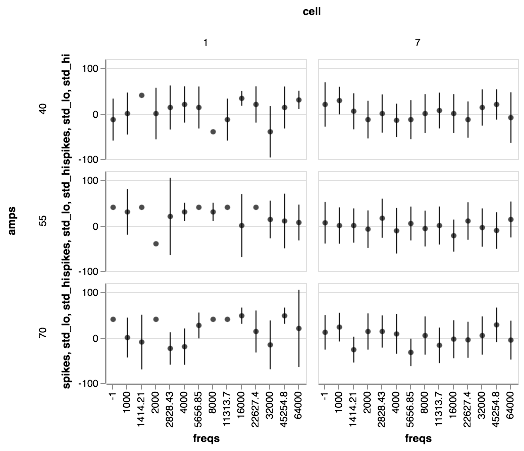

In [158]:
df_tc_summary['std_lo'] = df_tc_summary['spikes']-df_tc_summary['std']
df_tc_summary['std_hi'] = df_tc_summary['spikes']+df_tc_summary['std']

points = alt.Chart().mark_circle(
            ).encode(
                x=alt.X('freqs:O'),
                y=alt.Y('spikes:Q'),
                color=alt.value('black')
            ).properties(
                width = 200,
                height = 100
            )

bars = alt.Chart().mark_rule().encode(
y=alt.Y('std_lo:Q'),
y2=alt.Y('std_hi:Q'),
x=alt.X('freqs:O'))

chart = points+bars

chart.facet(row='amps:O',column='cell:N',data=df_tc_summary)


Or if we want to forget about uncertainty as a heatmap

In [181]:
def tc_heatmap(data, cell):
    points = alt.Chart(data[data['cell']==cell]).mark_rect(
                ).encode(
                    x=alt.X('freqs:O'),
                    y=alt.Y('amps:O'),
                    color='spikes:Q'
                ).properties(
                    width = 600,
                    height = 200
                )
    return points

In [182]:
interact(tc_heatmap,cell = sorted(df_tc_summary['cell'].unique()), data=fixed(df_tc_summary));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDcpLCB2YWx1ZT0xKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2XigKY=
